# rho-Simulated SBM, n=150,1500

In [2]:
#hide
%load_ext autoreload
%autoreload 1

import sys
sys.path
sys.path.insert(0,'../graspologic')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from pkg.gmp import quadratic_assignment
from pkg.gmp import quadratic_assignment_ot
from pkg.plot import set_theme
import numpy as np

# Experiment Summary, n = 150
Let $(G_1, G_2) \sim \rho-SBM(\vec{n},B)$. (NB: binary, symmetric, hollow.)

$K = 3$.

the marginal SBM is conditional on block sizes $\vec{n}=[n_1,n_2,n_3]$.

$B = [(.20,.01,.01);(.01,.10,.01);(.01,.01,.20)]$. (NB: rank($B$)=3 with evalues $\approx [0.212,0.190,0.098]$.)

with $n = 150$ and $\vec{n}=[n_1,n_2,n_3] = [50,50,50]$

for each $\rho \in \{0.5,0.6,\ldots,0.9,1.0\}$ generate $r$ replicates $(G_1, G_2)$.

For all $r$ replicates, run $GM$ and $GM_{LS}$ (where $GM_{LS}$ uses the "Lightspeed sinkhorn distances" for computing the step direction) each $t$ times, with each $t$ corresponding to a different random permutation on $G_2$ . 

Specifically,$G_2' = Q G_2 Q^T,$ where $Q$ is sampled uniformly from the set of $n x n$ permutations matrices.

For each $t$ permutation, run $GM$ & $GM_{SS}$ from the barycenter ($\gamma = 0$).

For each $r$, the $t$ permutation with the highest associated objective function value will have it's match ratio recorded

For any $\rho$ value, have $\delta$ denote the average match ratio over the $r$ realizations

Plot $x=\rho$ vs $y$= $\delta$ $\pm$ 2s.e.

Below contains figures for $r=50$, $t=10$ 



In [10]:
#hide
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
from joblib import Parallel, delayed
import seaborn as sns
# from graspy.match import GraphMatch as GMP
from graspologic.simulations import sbm_corr
# from scipy.optimize import linear_sum_assignment
from sklearn.metrics import pairwise_distances

r = 50
t=10
# gmp = GraphMatch('maximize':True, 'tol':0.000001,'maxiter':30, 'shuffle_input':True)
def match_ratio(inds, n):
    return np.count_nonzero(inds == np.arange(n)) / n

        
n = 150
m = r
rhos = 0.1 * np.arange(11)[5:]
# rhos = np.arange(8,10.5,0.5) *0.1
n_p = len(rhos)

ratios = np.zeros((n_p,m))
scores = np.zeros((n_p,m))

ratios_ss = np.zeros((n_p,m))
scores_ss = np.zeros((n_p,m))


n_per_block = int(n/3)
n_blocks = 3
block_members = np.array(n_blocks * [n_per_block])
block_probs = np.array([[0.2, 0.01, 0.01], [0.01, 0.1, 0.01], [0.01, 0.01, 0.2]])
directed = False
loops = False
for k, rho in enumerate(rhos):
    np.random.seed(8888)
    seeds = [np.random.randint(1e8, size=t) for i in range(m)]
    def run_sim(seed):
        
        A1, A2 = sbm_corr(
            block_members, block_probs, rho, directed=directed, loops=loops
        )
        score = 0
        res_opt = None

        score_ss = 0
        res_opt_ss = None

        for j in range(t):
            res = quadratic_assignment(A1,A2, options={'maximize':True, 'tol':0.000001,'maxiter':30, 'shuffle_input':True})
            if res.fun>score:
                perm = res.col_ind
                score = res.fun

            res_ss = quadratic_assignment_ls(A1,A2, options={'maximize':True, 'tol':0.000001,'maxiter':30, 'shuffle_input':True})
            if res_ss.fun>score_ss:
                perm_ss = res_ss.col_ind
                score_ss = res_ss.fun
                
        ratio = match_ratio(perm, n)

        ratio_ss = match_ratio(perm_ss, n)

        return ratio, score, ratio_ss, score_ss

    result = Parallel(n_jobs=-1, verbose=10)(delayed(run_sim)(seed) for seed in seeds)

    ratios[k,:] = [item[0] for item in result]
    scores[k,:] = [item[1] for item in result]
    ratios_ss[k,:] = [item[2] for item in result]
    scores_ss[k,:] = [item[3] for item in result]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  50 | elapsed:   38.2s remaining:  5.7min
[Parallel(n_jobs=-1)]: Done  11 out of  50 | elapsed:   46.6s remaining:  2.8min
[Parallel(n_jobs=-1)]: Done  17 out of  50 | elapsed:   51.3s remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  23 out of  50 | elapsed:   53.2s remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  29 out of  50 | elapsed:   56.2s remaining:   40.7s
[Parallel(n_jobs=-1)]: Done  35 out of  50 | elapsed:   58.5s remaining:   25.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  1.0min remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  1.1min remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  50 | elapsed:   36.1s remaining:  5.4min
[Parallel(n_jobs=-1)]: Done  11 out of  50 | e

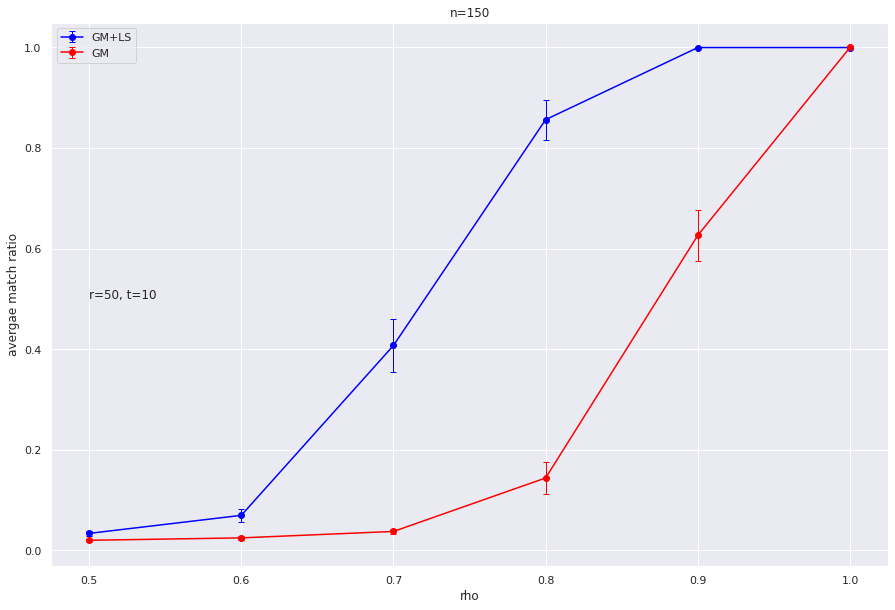

In [13]:
#collapse
from scipy.stats import sem
error = [sem(ratios[i,:]) for i in range(n_p)]
average = [np.mean(ratios[i,:] ) for i in range(n_p)]

error_ss = [sem(ratios_ss[i,:]) for i in range(n_p)]
average_ss = [np.mean(ratios_ss[i,:] ) for i in range(n_p)]

sns.set_context('poster')
sns.set(rc={'figure.figsize':(15,10)})
txt =f'r={r}, t={t}'
plt.errorbar(rhos,average_ss, error_ss,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GM+LS', color='blue')
# plt.errorbar(rhos,average_gmlap, error_gmlap,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GM+dissim(dist)')
plt.errorbar(rhos,average, error,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GM', color='red')
# plt.errorbar(rhos,average_lap, error_lap,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='LAP (dist)', color='yellow')
plt.xlabel("rho")
plt.ylabel("avergae match ratio")
plt.text(0.5,0.5,txt)
plt.title('n=150')
plt.legend()

# Experiment Summary, n = 1500
Let $(G_1, G_2) \sim \rho-SBM(\vec{n},B)$. (NB: binary, symmetric, hollow.)

$K = 3$.

the marginal SBM is conditional on block sizes $\vec{n}=[n_1,n_2,n_3]$.

$B = [(.20,.01,.01);(.01,.10,.01);(.01,.01,.20)]$. (NB: rank($B$)=3 with evalues $\approx [0.212,0.190,0.098]$.)

with $n = 150$ and $\vec{n}=[n_1,n_2,n_3] = [50,50,50]$

for each $\rho \in \{0.8, 0.85, 0.9, 0.95, 1.0\}$ generate $r$ replicates $(G_1, G_2)$.

For all $r$ replicates, run $GM$ and $GM_{LS}$ (where $GM_{LS}$ uses the "Lightspeed sinkhorn distances" for computing the step direction) each $t$ times, with each $t$ corresponding to a different random permutation on $G_2$ . 

Specifically,$G_2' = Q G_2 Q^T,$ where $Q$ is sampled uniformly from the set of $n x n$ permutations matrices.

For each $t$ permutation, run $GM$ & $GM_{SS}$ from the barycenter ($\gamma = 0$).

For each $r$, the $t$ permutation with the highest associated objective function value will have it's match ratio recorded

For any $\rho$ value, have $\delta$ denote the average match ratio over the $r$ realizations

Plot $x=\rho$ vs $y$= $\delta$ $\pm$ s.e.

Below contains figures for $r=25$, $t=5$ 

In [83]:
#hide
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
from joblib import Parallel, delayed
import seaborn as sns
# from graspy.match import GraphMatch as GMP
from graspologic.simulations import sbm_corr
# from scipy.optimize import linear_sum_assignment
from sklearn.metrics import pairwise_distances

r = 25
t=5
# gmp = GraphMatch('maximize':True, 'tol':0.000001,'maxiter':30, 'shuffle_input':True)
def match_ratio(inds, n):
    return np.count_nonzero(inds == np.arange(n)) / n

        
n = 1500
m = r
# rhos = 0.1 * np.arange(11)[5:]
rhos = np.arange(8,10.5,0.5) *0.1
n_p = len(rhos)

ratios = np.zeros((n_p,m))
scores = np.zeros((n_p,m))

ratios_ss = np.zeros((n_p,m))
scores_ss = np.zeros((n_p,m))


n_per_block = int(n/3)
n_blocks = 3
block_members = np.array(n_blocks * [n_per_block])
block_probs = np.array([[0.2, 0.01, 0.01], [0.01, 0.1, 0.01], [0.01, 0.01, 0.2]])
directed = False
loops = False
for k, rho in enumerate(rhos):
    np.random.seed(8888)
    seeds = [np.random.randint(1e8, size=t) for i in range(m)]
    def run_sim(seed):
        
        A1, A2 = sbm_corr(
            block_members, block_probs, rho, directed=directed, loops=loops
        )
        score = 0
        res_opt = None

        score_ss = 0
        res_opt_ss = None

        for j in range(t):
            res = quadratic_assignment(A1,A2, options={'maximize':True, 'tol':0.000001,'maxiter':30, 'shuffle_input':True})
            if res.fun>score:
                perm = res.col_ind
                score = res.fun

            res_ss = quadratic_assignment_ls(A1,A2, options={'maximize':True, 'tol':0.000001,'maxiter':30, 'shuffle_input':True})
            if res_ss.fun>score_ss:
                perm_ss = res_ss.col_ind
                score_ss = res_ss.fun
                
        ratio = match_ratio(perm, n)

        ratio_ss = match_ratio(perm_ss, n)

        return ratio, score, ratio_ss, score_ss

    result = Parallel(n_jobs=-1, verbose=10)(delayed(run_sim)(seed) for seed in seeds)

    ratios[k,:] = [item[0] for item in result]
    scores[k,:] = [item[1] for item in result]
    ratios_ss[k,:] = [item[2] for item in result]
    scores_ss[k,:] = [item[3] for item in result]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  25 | elapsed:  8.1min remaining: 42.7min
[Parallel(n_jobs=-1)]: Done   7 out of  25 | elapsed:  8.2min remaining: 21.1min
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed: 10.7min remaining: 16.1min
[Parallel(n_jobs=-1)]: Done  13 out of  25 | elapsed: 14.0min remaining: 12.9min
[Parallel(n_jobs=-1)]: Done  16 out of  25 | elapsed: 14.8min remaining:  8.3min
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed: 15.9min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed: 17.6min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 19.2min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 19.2min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 56 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  25 | elapsed:  7.6min remaining: 39.9min
[Parallel(n_jobs=-1)]: Done   7 out of  25 | e

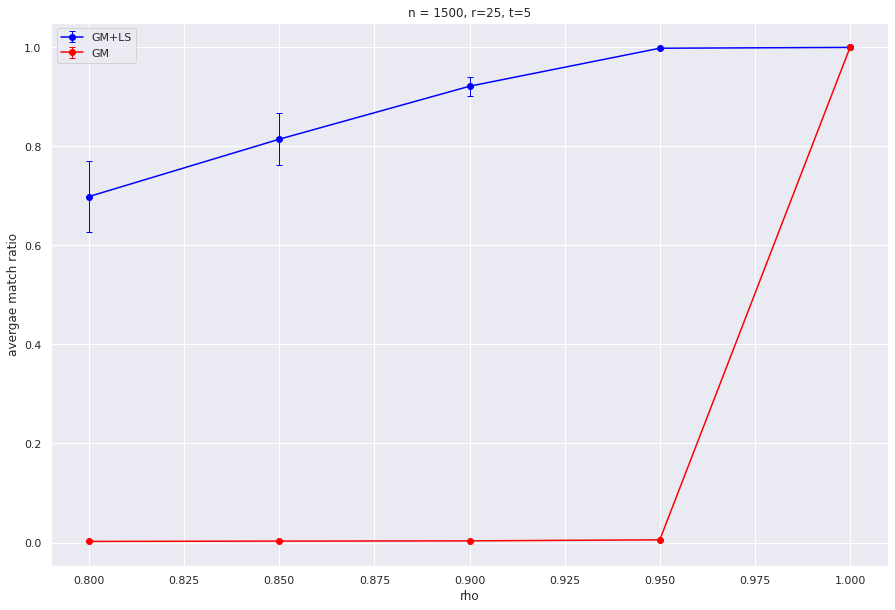

In [93]:
#collapse
from scipy.stats import sem
# error_1500 = [sem(ratios[i,:]) for i in range(n_p)]
# average_1500 = [np.mean(ratios[i,:] ) for i in range(n_p)]

# error_ss_1500 = [sem(ratios_ss[i,:]) for i in range(n_p)]
# average_ss_1500 = [np.mean(ratios_ss[i,:] ) for i in range(n_p)]

sns.set_context('poster')
sns.set(rc={'figure.figsize':(15,10)})
txt =f'r={r}, t={t}'
plt.figure()
plt.errorbar(rhos_1500,average_ss, error_ss,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GM+LS', color='blue')
# plt.errorbar(rhos,average_gmlap, error_gmlap,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GM+dissim(dist)')
plt.errorbar(rhos,average, error,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='GM', color='red')
# plt.errorbar(rhos,average_lap, error_lap,marker='o',capsize=3, elinewidth=1, markeredgewidth=1, label='LAP (dist)', color='yellow')
plt.xlabel("rho")
plt.ylabel("avergae match ratio")
# plt.text(0.5,0.5,txt)
plt.title(f'n = 1500, {txt}')
plt.legend()